In [88]:
import gzip
import math
import random
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import tensorflow as tf
from sklearn import linear_model

In [2]:
def parseData(fname, lines=100, limit=True):
    count = 0
    for l in open(fname, "rt"):
        count += 1
        yield eval(l)
        if limit and count > lines:
            break

In [3]:
fileName = "reviews.json"

In [4]:
dataDir = "/Users/cairui/Downloads/lthing_data/"

In [5]:
originalDataset = list(parseData(dataDir + fileName, limit=False))

In [6]:
len(originalDataset)

1707070

In [7]:
originalDataset[0]

{'work': '3206242',
 'flags': [],
 'unixtime': 1194393600,
 'stars': 5.0,
 'nhelpful': 0,
 'time': 'Nov 7, 2007',
 'comment': 'This a great book for young readers to be introduced to the world of Middle Earth. ',
 'user': 'van_stef'}

In [20]:
test = [d for d in originalDataset if 'stars' in d and d['stars'] == 4.5]

In [179]:
len(relations)

219790

In [8]:
count = 0
relations = []
for l in open(dataDir + "edges.txt"):
    u,i = l.strip().split(' ')
    relations.append((u, i))
    count += 1
#     if count == 10: break

In [9]:
relations[:10]

[('Rodo', 'anehan'),
 ('Rodo', 'sevilemar'),
 ('Rodo', 'dingsi'),
 ('Rodo', 'slash'),
 ('RelaxedReader', 'AnnRig'),
 ('RelaxedReader', 'bookbroke'),
 ('RelaxedReader', 'Bumpersmom'),
 ('RelaxedReader', 'DivaColumbus'),
 ('RelaxedReader', 'AnnRig'),
 ('RelaxedReader', 'bookbroke')]

In [69]:
userIDs = {}
itemIDs = {}
interactions = []
interactionsWithRating = []
interactionsPerUser = defaultdict(list)

for d in originalDataset:
    u = d['user']
    i = d['work']
    t = d['unixtime']
    if t == None or t == -86400: continue
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((t,u,i))
    interactionsPerUser[u].append((t,i))
    if ('stars' in d and d['stars'] != None): 
        interactionsWithRating.append((t, u, i, d['stars']))

In [13]:
relationUserIDs = set()
for r in relations:
    relationUserIDs.add(r[0])
    relationUserIDs.add(r[1])

In [14]:
len(relationUserIDs)

65946

In [16]:
len(userIDs)

82833

In [17]:
bothUser = [u for u in relationUserIDs if u in userIDs]

In [18]:
len(bothUser)

28593

In [180]:
relationCount = 0
bothUser = set()
for u1, u2 in relations:
    if u1 in userIDs and u2 in userIDs:
        relationCount += 1
        bothUser.add(u1)
        bothUser.add(u2)
print(userCount)
print(len(bothUser))

129307
24096


# FPMC

In [32]:
interactions[0]

(1194393600, 'van_stef', '3206242')

In [33]:
len(interactions)

1701037

In [36]:
interactions.sort()

In [37]:
itemIDs['dummy'] = len(itemIDs)

In [38]:
interactionsWithPrevious = []

for u in interactionsPerUser:
    interactionsPerUser[u].sort()
    lastItem = 'dummy'
    for (t,i) in interactionsPerUser[u]:
        interactionsWithPrevious.append((t,u,i,lastItem))
        lastItem = i

In [40]:
itemsPerUser = defaultdict(set)
for _,u,i in interactions:
    itemsPerUser[u].add(i)

In [41]:
items = list(itemIDs.keys())

In [44]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [45]:
class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

    # Prediction for a single instance
    def predict(self, u, i, j):
        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))

    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_k = tf.nn.embedding_lookup(self.betaI, k)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

In [46]:
def trainingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            _,u,i,j = random.choice(interactions) # positive sample
            k = random.choice(items) # negative sample
            while k in itemsPerUser[u]:
                k = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
            sampleK.append(itemIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [48]:
interactionsWithPrevious[0]

(1191024000, 'van_stef', '2259992', 'dummy')

In [50]:
len(interactionsWithPrevious)

1701037

In [51]:
interactionsTrain = interactionsWithPrevious[:1500000]
interactionsTest = interactionsWithPrevious[1500000:]

In [52]:
modelFPMC = FPMC(5, 0.001, 1, 1)

Metal device set to: Apple M1 Pro


2021-11-28 17:34:20.100630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-28 17:34:20.101374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [58]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for _,u,i,j in interactionsTest:
    interactionsTestPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)
itemList = list(itemSet)

In [62]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    li = list(interactionsTestPerUser[u])
    positive = random.sample(li,N)
    negative = random.sample(itemList,N)
    for (i,j),k in zip(positive,negative):
        sp = model.predict(userIDs[u], itemIDs[i], itemIDs[j]).numpy()
        sn = model.predict(userIDs[u], itemIDs[k], itemIDs[j]).numpy()
        if sp > sn:
            win += 1
    return win/N

In [64]:
def AUC(model, N):
    av = []
    count = 0
    for u in interactionsTestPerUser:
        av.append(AUCu(model, u, 10))
        count += 1
        if count > N: break
    return sum(av) / len(av)

In [56]:
for i in range(100):
    obj = trainingStep(modelFPMC, interactionsTrain)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 1.778976
iteration 20, objective = 1.3580587
iteration 30, objective = 0.7759166
iteration 40, objective = 0.763352
iteration 50, objective = 0.7209007
iteration 60, objective = 0.70743734
iteration 70, objective = 0.7032454
iteration 80, objective = 0.7015118
iteration 90, objective = 0.7013443
iteration 100, objective = 0.7013688


In [65]:
# print("AUC = " + str(AUC(modelFPMC, 100)))

KeyboardInterrupt: 

# Sliding window, linear regression

In [25]:
ratingsTime = [(d['unixtime'], d['stars']) for d in originalDataset if 'stars' in d and d['stars'] != None and 'unixtime' in d and d['unixtime'] != -86400 and d['unixtime'] != None]

In [26]:
ratingsTime.sort()
len(ratingsTime)

1383597

In [55]:
wSize = 10000
xu = [r[0] for r in ratingsTime] # as unix times
y = [r[1] for r in ratingsTime] # ratings

In [56]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [57]:
for i in range(wSize,len(xu)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [58]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

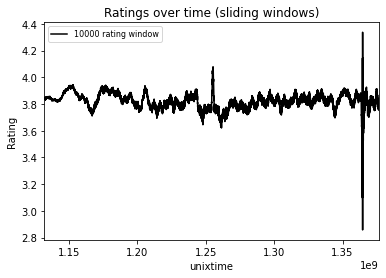

In [59]:
plt.plot(X, Y, label="10000 rating window", color='k')
# plt.xticks([X[600], X[-350]], [x[wSize+600].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("unixtime")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

In [50]:
len(interactionsPerUser)

82833

In [52]:
test = [len(s) for s in interactionsPerUser]

In [53]:
np.min(test)

0

In [70]:
len(interactionsWithRating)

1383597

In [71]:
interactionsWithRating[:10]

[(1194393600, 'van_stef', '3206242', 5.0),
 (1333756800, 'dwatson2', '12198649', 5.0),
 (1364515200, 'amdrane2', '12981302', 4.0),
 (1270944000, 'Lila_Gustavus', '5231009', 3.0),
 (1231372800, 'skinglist', '184318', 2.0),
 (1229644800, 'saibaby79', '364456', 4.0),
 (1160265600, 'justine', '3067', 4.5),
 (1303430400, 'aulsmith', '4857142', 4.0),
 (1171238400, 'ChelseaBottomley', '45518', 2.5),
 (1262736000, 'wondersdisciple', '20028', 3.5)]

In [73]:
interactionsWithRating.sort()

In [74]:
itTrain = interactionsWithRating[:1200000]
itTest = interactionsWithRating[1200000:]

In [79]:
userReviews = defaultdict(list)
itemReviews = defaultdict(list)
for d in itTrain:
    userReviews[d[1]].append(d[3])
    itemReviews[d[2]].append(d[3])

In [139]:
userAvgRatings = defaultdict(float)
itemAvgRatings = defaultdict(float)
for u in userReviews:
    userAvgRatings[u] = np.mean(np.array(userReviews[u]))
for i in itemReviews:
    itemAvgRatings[i] = np.mean(np.array(itemReviews[i]))

In [161]:
w_size = 100
Xtrain = []
ytrain = []
for i in range(w_size, len(itTrain) - 1):
    u, item, r = itTrain[i][1], itTrain[i][2], itTrain[i][3]
    sample = itTrain[i - w_size : i]
    feature = [d[3] for d in sample]
#     feature.append(userAvgRatings[u])
#     feature.append(itemAvgRatings[item])
    feature.append(1)
    Xtrain.append(feature)
    ytrain.append(r)

In [162]:
Xtest = []
ytest = []
for i in range(w_size, len(itTest) - 1):
    u, item, r = itTest[i][1], itTest[i][2], itTest[i][3]
    sample = itTest[i - w_size : i]
    feature = [d[3] for d in sample]
#     feature.append(userAvgRatings[u])
#     feature.append(itemAvgRatings[item])
    feature.append(1)
    Xtest.append(feature)
    ytest.append(r)

In [176]:
ytest = np.array(ytest)

In [163]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(Xtrain, ytrain)

LinearRegression(fit_intercept=False)

In [164]:
ypred = model.predict(Xtest)

In [165]:
def MSE(ypred, ytest):
    return np.mean((ypred - ytest) ** 2)

In [169]:
def R_sq(ypred, ytest):
    return 1 - np.mean((ypred - ytest) ** 2) / np.var(ytest)

In [170]:
MSE(ypred, ytest)

0.9468799014416787

In [171]:
R_sq(ypred, ytest)

0.0703242808982909

In [177]:
# Check binary error rate, see report section 2
TP = sum( np.logical_and(ypred>=4.0, ytest>=4.0) )
FP = sum( np.logical_and(ypred>=4.0, ytest<4.0) )
TN = sum( np.logical_and(ypred<4.0, ytest<4.0) )
FN = sum( np.logical_and(ypred<4.0, ytest>=4.0) )

assert TP+FP+TN+FN == len(ytest)

Accuracy = (TP + TN) / len(ytest)
BER = 1 - 0.5*(TP / (TP + FN) + TN / (TN + FP))
print(f"TP:{TN}, FP:{FP}, TN:{TN}, FN:{FN}")
print(f"Accuracy:{Accuracy}, BER:{BER}")

TP:65173, FP:5705, TN:65173, FN:93259
Accuracy:0.46067489209574053, BER:0.45429536192002706


# Read in data

In [255]:
userIDs = {}
itemIDs = {}
interactions = []
interactionsWithRating = []
interactionsPerUser = defaultdict(list)

for d in originalDataset:
    u = d['user']
    i = d['work']
    t = d['unixtime']
    if t == None or t == -86400: continue
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((t,u,i))
    interactionsPerUser[u].append((t,i))
    if ('stars' in d and d['stars'] != None): 
        interactionsWithRating.append((t, u, i, d['stars']))

In [343]:
dataWithRatings = [d for d in originalDataset if 'stars' in d and d['stars'] != None and 'unixtime' in d and d['unixtime'] != -86400 and d['unixtime'] != None]
# dataWithRatings = [d for d in originalDataset if 'stars' in d and d['stars'] != None]

In [344]:
len(dataWithRatings)

1383597

In [345]:
# 8:2 train-test split
cut = int(len(dataWithRatings) * 0.8)
train_data, test_data = dataWithRatings[:cut], dataWithRatings[cut:]
del dataWithRatings # save memory

In [404]:
usersPerItem = defaultdict(list)
itemsPerUser = defaultdict(list)

# very likely to have same ratings, so use list
ratingsPerItem = defaultdict(list)
ratingsPerUser = defaultdict(list)

# Each User has a list of length 3: nhelpful, #abuse, #not_a_review
recordPerUser = defaultdict(lambda:[0,0,0])

for d in train_data:
    
    u, i, r, dt = d['user'], d['work'], d['stars'], d['unixtime']
    usersPerItem[i].append( (dt, u) )
    itemsPerUser[u].append( (dt, i) )
    ratingsPerItem[i].append(r)
    ratingsPerUser[u].append(r)
    
    if d['nhelpful']:
        recordPerUser[u][0] += d['nhelpful']
    if d['flags']:
        if 'abuse' in d['flags']:
            recordPerUser[u][1] += 1
        if 'not_a_review' in d['flags']:
            recordPerUser[u][2] += 1

# calculate 2 global averages for cold-start user or book: average of each user's/book's average ratings
avgBookRating = sum( sum(ratingsPerItem[i])/len(ratingsPerItem[i]) for i in ratingsPerItem)/len(ratingsPerItem)
avgUserRating = sum( sum(ratingsPerUser[u])/len(ratingsPerUser[u]) for u in ratingsPerUser)/len(ratingsPerUser)
print(avgBookRating, avgUserRating)

3.7653503816851766 3.9605122606260252


In [410]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratingUserItem = {}
for d in train_data:  
    u, i, r = d['user'], d['work'], d['stars']
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)
    ratingUserItem[(u, i)] = r

In [348]:
print(f"A total of {len(recordPerUser)} users out of {len(itemsPerUser)} have helpful votes, abuse review, or not-a-review")

A total of 26049 users out of 65546 have helpful votes, abuse review, or not-a-review


In [349]:
len(userIDs) ### Number of users in the original dataset

82833

In [350]:
len(itemsPerUser) ### Number of users in the training dataset after filtering

65546

In [425]:
def testModel(featureFunc):
    Xtrain = np.array( [featureFunc(d) for d in train_data] )
    Xtest = np.array( [featureFunc(d) for d in test_data] )

    Ytrain = np.array( [d['stars'] for d in train_data] )
    Ytest = np.array( [d['stars'] for d in test_data] )
    
    model = linear_model.Ridge(alpha=1000, fit_intercept=False)
    model.fit(Xtrain, Ytrain)

    Ypred = model.predict(Xtest)
    
    # Check binary error rate, see report section 2
    TP = sum( np.logical_and(Ypred>=4.0, Ytest>=4.0) )
    FP = sum( np.logical_and(Ypred>=4.0, Ytest<4.0) )
    TN = sum( np.logical_and(Ypred<4.0, Ytest<4.0) )
    FN = sum( np.logical_and(Ypred<4.0, Ytest>=4.0) )

    assert TP+FP+TN+FN == len(Ytest)

    Accuracy = (TP + TN) / len(Ytest)
    BER = 1 - 0.5*(TP / (TP + FN) + TN / (TN + FP))
    print(f"TP:{TN}, FP:{FP}, TN:{TN}, FN:{FN}")
    print(f"Accuracy:{Accuracy}, BER:{BER}")
    print(f"Test MSE:{MSE(Ypred, Ytest)}")
    
    return model, MSE(Ypred, Ytest), R_sq(Ypred, Ytest), Accuracy, BER

In [445]:
def roundToHalf(ratings):
    return [round(r / 0.5, 0) * 0.5 for r in ratings]

# Baseline

In [447]:
def feature_baseline(d):
    global avgBookRating, avgUserRating
    result = [1] # bias term
    u, i = d['user'], d['work']
    if u in ratingsPerUser:
        result.append( np.mean(ratingsPerUser[u]))
    else:
        result.append(avgUserRating)
    if i in ratingsPerItem:
        result.append( np.mean(ratingsPerItem[i]) )
    else:
        result.append(avgBookRating)
    return result

In [448]:
Xtrain_baseline = np.array( [feature_baseline(d) for d in train_data] )
Xtest_baseline = np.array( [feature_baseline(d) for d in test_data] )

Ytrain = np.array( [d['stars'] for d in train_data] )
Ytest = np.array( [d['stars'] for d in test_data] )

In [449]:
model_baseline = linear_model.LinearRegression()
model_baseline.fit(Xtrain_baseline, Ytrain)

Ypred_baseline = model_baseline.predict(Xtest_baseline)
Ypred_baseline

array([3.13437341, 4.13792668, 4.23084309, ..., 3.66410186, 3.55441613,
       4.53088522])

In [450]:
MSE(Ypred_baseline, Ytest)

0.848704559199519

In [451]:
MSE(roundToHalf(Ypred_baseline), Ytest)

0.8692586368892744

In [356]:
R_sq(Ypred_baseline, Ytest)

0.14835923148656704

In [454]:
Ypred_baseline = np.array(roundToHalf(Ypred_baseline))

In [455]:
# Check binary error rate, see report section 2
TP = sum( np.logical_and(Ypred_baseline>=4.0, Ytest>=4.0) )
FP = sum( np.logical_and(Ypred_baseline>=4.0, Ytest<4.0) )
TN = sum( np.logical_and(Ypred_baseline<4.0, Ytest<4.0) )
FN = sum( np.logical_and(Ypred_baseline<4.0, Ytest>=4.0) )

assert TP+FP+TN+FN == len(Ytest)

Accuracy = (TP + TN) / len(Ytest)
BER = 1 - 0.5*(TP / (TP + FN) + TN / (TN + FP))
print(f"TP:{TN}, FP:{FP}, TN:{TN}, FN:{FN}")
print(f"Accuracy:{Accuracy}, BER:{BER}")

TP:66436, FP:37519, TN:66436, FN:53744
Accuracy:0.6701973113616653, BER:0.33599865389818273


In [427]:
testModel(feature_baseline)

TP:86476, FP:17479, TN:86476, FN:93461
Accuracy:0.5990893321769297, BER:0.3545559504821649
Test MSE:0.8473022145076765


(Ridge(alpha=1000, fit_intercept=False),
 0.8473022145076765,
 0.1497664277813624,
 0.5990893321769297,
 0.3545559504821649)

# Social

In [359]:
relations[:10]

[('Rodo', 'anehan'),
 ('Rodo', 'sevilemar'),
 ('Rodo', 'dingsi'),
 ('Rodo', 'slash'),
 ('RelaxedReader', 'AnnRig'),
 ('RelaxedReader', 'bookbroke'),
 ('RelaxedReader', 'Bumpersmom'),
 ('RelaxedReader', 'DivaColumbus'),
 ('RelaxedReader', 'AnnRig'),
 ('RelaxedReader', 'bookbroke')]

In [360]:
friendsOfUser = defaultdict(set)
for d in relations:
    u1, u2 = d[0], d[1]
    if u1 in itemsPerUser and u2 in itemsPerUser:
        friendsOfUser[u1].add(u2)
        friendsOfUser[u2].add(u1)


In [361]:
len(friendsOfUser) ### Number of users who has at least 1 friend who also has a review in the dataset

20369

In [362]:
len(itemsPerUser)

65546

In [363]:
friendsCount = [len(friendsOfUser[u]) for u in friendsOfUser]
friendsCount.sort()
friendsCount[-20:]

[173,
 178,
 180,
 187,
 188,
 189,
 189,
 191,
 192,
 214,
 217,
 226,
 230,
 243,
 274,
 325,
 328,
 385,
 1194,
 1698]

In [428]:
def feature_social_friend_avg_rating(d):
    global avgBookRating, avgUserRating
    result = [1] # bias term
    u, i = d['user'], d['work']
    if u in ratingsPerUser:
        result.append( np.mean(ratingsPerUser[u]) )
    else:
        result.append(avgUserRating)
    if i in ratingsPerItem:
        result.append( np.mean(ratingsPerItem[i]) )
    else:
        result.append(avgBookRating)
    if u in friendsOfUser:
        friendsRatings = []
        for f in friendsOfUser[u]:
            friendsRatings += ratingsPerUser[f]
        result.append( np.mean(friendsRatings) )
    else:
        result.append( avgUserRating )
#     result.append( avgUserRating )
    return result

In [429]:
model_social_friend_avg_rating, mse, r_sq, accuracy, ber = testModel(feature_social_friend_avg_rating)

TP:86537, FP:17418, TN:86537, FN:93551
Accuracy:0.5989845331020526, BER:0.35452302372490885
Test MSE:0.8480617928222299


In [366]:
model_social_friend_avg_rating.coef_

array([-1.84094933,  0.66113632,  0.83298016, -0.01001935])

In [367]:
mse

0.8487737056295157

# Social (Jaccard similarity as weights)

In [368]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [369]:
def feature_social_jaccard(d):
    global avgBookRating, avgUserRating
    result = [1] # bias term
    u, i = d['user'], d['work']
    if u in ratingsPerUser:
        result.append( np.mean(ratingsPerUser[u]) )
    else:
        result.append(avgUserRating)
    if i in ratingsPerItem:
        result.append( np.mean(ratingsPerItem[i]) )
    else:
        result.append(avgBookRating)
    if u in friendsOfUser:
        mostSimilarFriend = '' # the most similar friend
        highestSim = -1 # highest Jaccard sim
        for f in friendsOfUser[u]:
            sim = Jaccard(itemsPerUser[u], itemsPerUser[f])
            if  sim > highestSim:
                highestSim = sim
                mostSimilarFriend = f
        result.append( np.mean(ratingsPerUser[mostSimilarFriend]) ) # avg rating of the most similar friend
    else:
        result.append( avgUserRating )
    return result

In [370]:
model_social_jaccard, mse, r_sq, accuracy, ber = testModel(feature_social_jaccard)

TP:86380, FP:17575, TN:86380, FN:93035
Accuracy:0.6002818733738075, BER:0.35378480012838354


In [371]:
model_social_jaccard.coef_

array([-1.8532308 ,  0.66090918,  0.83297046, -0.00661091])

In [372]:
mse

0.8487635430177866

# Social (how many friends have read this book?)

In [373]:
def feature_social_friend_count(d):
    global avgBookRating, avgUserRating
    result = [1] # bias term
    u, i = d['user'], d['work']
    if u in ratingsPerUser:
        result.append( np.mean(ratingsPerUser[u]) )
    else:
        result.append(avgUserRating)
    if i in ratingsPerItem:
        result.append( np.mean(ratingsPerItem[i]) )
    else:
        result.append(avgBookRating)
    if u in friendsOfUser:
        mostSimilarFriend = '' # the most similar friend
        highestSim = -1 # highest Jaccard sim
        friendCount = 0 # how many friends have also read this book?
        for f in friendsOfUser[u]:
            if i in itemsPerUser[f]: friendCount += 1
            sim = Jaccard(itemsPerUser[u], itemsPerUser[f])
            if  sim > highestSim:
                highestSim = sim
                mostSimilarFriend = f
        result.append( np.mean(ratingsPerUser[mostSimilarFriend]) ) # avg rating of the most similar friend
        result.append( friendCount )  # how many friends have also read this book?
    else:
        result.append( avgUserRating )
        result.append(0)
    return result

In [374]:
model_social_friend_count, mse, r_sq, accuracy, ber = testModel(feature_social_friend_count)

TP:86368, FP:17587, TN:86368, FN:92862
Accuracy:0.6008636889274357, BER:0.353341837295293


In [375]:
mse

0.848344859990583

In [376]:
model_social_friend_count.coef_

array([-1.86117215,  0.66134389,  0.83197384, -0.00492701,  0.02922094])

# Interaction (Most similar user's rating on this book)

In [386]:
def feature_social_sim_user_rating_on_book(d):
    global avgBookRating, avgUserRating
    result = [1] # bias term
    u, i = d['user'], d['work']
    if u in ratingsPerUser:
        result.append( np.mean(ratingsPerUser[u]) )
    else:
        result.append(avgUserRating)
    if i in ratingsPerItem:
        result.append( np.mean(ratingsPerItem[i]) )
    else:
        result.append(avgBookRating)
    if u in friendsOfUser:
        mostSimilarFriend = '' # the most similar friend
        highestSim = -1 # highest Jaccard sim
        friendCount = 0 # how many friends have also read this book?
        for f in friendsOfUser[u]:
            if i in itemsPerUser[f]: friendCount += 1
            sim = Jaccard(itemsPerUser[u], itemsPerUser[f])
            if  sim > highestSim:
                highestSim = sim
                mostSimilarFriend = f
#         result.append( np.mean(ratingsPerUser[mostSimilarFriend]) ) # avg rating of the most similar friend
        result.append( friendCount )  # how many friends have also read this book?
    else:
#         result.append( avgUserRating )
        result.append(0)
        
        
    mostSimUser = '' # the most similar user
    highestSim = -1 #highest Jaccard sim
    for u1 in usersPerItem[i]:
        if u1 == u: continue
        sim = Jaccard(itemsPerUser[u1], itemsPerUser[u])
        if sim > highestSim:
            highestSim = sim
            mostSimUser = u1
    if mostSimUser != '':
        result.append(ratingUserItem[(mostSimUser, i)]) # Most similar user's rating on this book
    else:
        result.append( avgUserRating )
    
    return result

In [383]:
model_social_sim_user_rating_on_book, mse, r_sq, accuracy, ber = testModel(feature_social_sim_user_rating_on_book)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [440]:
Xtrain = np.array( [feature_social_sim_user_rating_on_book(d) for d in train_data] )
Xtest = np.array( [feature_social_sim_user_rating_on_book(d) for d in test_data] )


In [441]:

Ytrain = np.array( [d['stars'] for d in train_data] )
Ytest = np.array( [d['stars'] for d in test_data] )

In [442]:
model = linear_model.Ridge(alpha=10000, fit_intercept=False)
model.fit(Xtrain, Ytrain)

Ridge(alpha=10000, fit_intercept=False)

In [443]:
Ypred = model.predict(Xtest)
MSE(Ypred, Ytest)

0.8451149857472132

In [444]:
Ypred_train = model.predict(Xtrain)
MSE(Ypred_train, Ytrain)

0.4969897860005439